In [1]:
# --- STEP 0: ENVIRONMENT FIX (Run this first!) ---
# If your imports are hanging or crashing, run this cell and then RESTART THE KERNEL.
import sys
%pip install "numpy<2.0" pandas fastf1 matplotlib scikit-learn scipy joblib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# --- STEP 1: IMPORT LIBRARIES & SETUP PATHS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib  # For saving the model
import os
import fastf1 # Added for fallback data fetching
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define File Paths (Relative to the 'notebooks' folder)
# We use '..' to go up one level to the project root
DATA_DIR = '../data'
MODELS_DIR = '../models'
DATA_PATH = os.path.join(DATA_DIR, 'clean_lap_data.csv')
MODEL_PATH = os.path.join(MODELS_DIR, 'tire_models_v1.pkl')

# Ensure these directories exist (Create them if they don't)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"📂 Data Directory: {os.path.abspath(DATA_DIR)}")
print(f"📂 Models Directory: {os.path.abspath(MODELS_DIR)}")

📂 Data Directory: d:\PROJECTS\f1-dynamic-strategy-optimization\data
📂 Models Directory: d:\PROJECTS\f1-dynamic-strategy-optimization\models


In [3]:
# 2. Load the Data
try:
    data = pd.read_csv(DATA_PATH)
    print(f"✅ Data loaded successfully from {DATA_PATH}!")
except FileNotFoundError:
    print(f"⚠️ '{DATA_PATH}' not found. Fetching data directly from FastF1...")
    
    # --- FALLBACK: Fetch Data on the fly ---
    # Setup cache
    cache_dir = '../backend/cache' # Centralize cache in backend folder if possible
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    fastf1.Cache.enable_cache(cache_dir)
    
    # Load Session (Bahrain 2024)
    print("Downloading Bahrain 2024 data...")
    session = fastf1.get_session(2024, 'Bahrain', 'R')
    session.load()
    
    # Process Data for Max Verstappen
    driver = 'VER'
    laps = session.laps.pick_driver(driver)
    clean_laps = laps.pick_quicklaps().reset_index()
    clean_laps['LapTimeSeconds'] = clean_laps['LapTime'].dt.total_seconds()
    
    # Select columns
    columns_we_need = ['LapNumber', 'TyreLife', 'LapTimeSeconds', 'Compound', 'Stint']
    data = clean_laps[columns_we_need].copy()
    
    # Save for next time in the correct folder
    data.to_csv(DATA_PATH, index=False)
    print(f"✅ Data fetched and saved to '{DATA_PATH}'")

✅ Data loaded successfully from ../data\clean_lap_data.csv!



Training models for: ['SOFT' 'HARD']

--- SOFT Model Results ---
Base Lap Time (Intercept): 95.73 seconds
Degradation per Lap (Slope): +0.011 seconds/lap
Accuracy (MAE): +/- 1.255 seconds

--- HARD Model Results ---
Base Lap Time (Intercept): 94.84 seconds
Degradation per Lap (Slope): +0.068 seconds/lap
Accuracy (MAE): +/- 0.126 seconds


d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


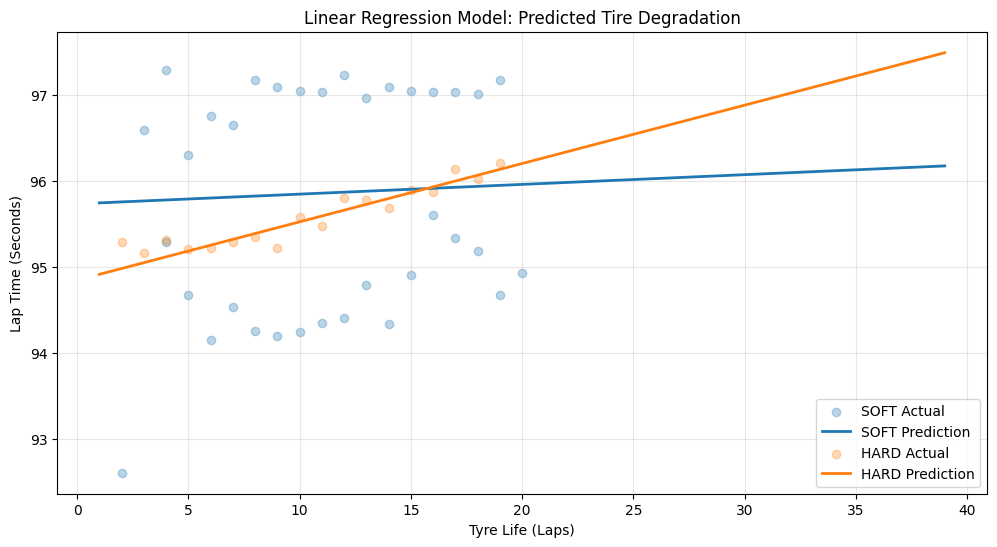

In [4]:
# 3. Feature Engineering
compounds = data['Compound'].unique()
models = {}

print(f"\nTraining models for: {compounds}")

# 4. Train a Model for Each Compound
plt.figure(figsize=(12, 6))

for compound in compounds:
    # Filter data for this specific tire
    compound_data = data[data['Compound'] == compound]
    
    # Define Features (X) and Target (y)
    X = compound_data[['TyreLife']]  # Features must be a DataFrame (2D)
    y = compound_data['LapTimeSeconds']
    
    # Split into Training and Testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and Train the Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Save the trained model to our dictionary
    models[compound] = model
    
    # Evaluate the Model
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"\n--- {compound} Model Results ---")
    print(f"Base Lap Time (Intercept): {model.intercept_:.2f} seconds")
    print(f"Degradation per Lap (Slope): +{model.coef_[0]:.3f} seconds/lap")
    print(f"Accuracy (MAE): +/- {mae:.3f} seconds")
    
    # Visualization: Plot the "Best Fit Line"
    plt.scatter(X, y, label=f"{compound} Actual", alpha=0.3)
    
    # Create a smooth line for the prediction
    range_line = np.arange(1, 40).reshape(-1, 1)
    plt.plot(range_line, model.predict(range_line), label=f"{compound} Prediction", linewidth=2)

# Finalize Plot
plt.xlabel("Tyre Life (Laps)")
plt.ylabel("Lap Time (Seconds)")
plt.title("Linear Regression Model: Predicted Tire Degradation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# 5. Save the Models (The "Brain")
# We save this dictionary of models so our Backend can use it later
joblib.dump(models, MODEL_PATH)
print(f"\n✅ Models saved to '{MODEL_PATH}'. Ready for Backend!")


✅ Models saved to '../models\tire_models_v1.pkl'. Ready for Backend!
